# Crime Prediction and Classification

In [153]:
import os
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [154]:
# Collecting the xlsx files from the current working directory

path = os.getcwd()
files = os.listdir(path)
excel_files = [filename for filename in files if filename[-4:] == "xlsx"]
excel_files

['Kerala-Analysis-22042020.xlsx',
 'Kerala-Analysis-28042020.xlsx',
 'Kerala-Analysis-29042020.xlsx',
 'Kerala-Analysis-30042020.xlsx']

##### Currently we've 4 xlsx files

In [155]:
# Loading the excel sheet in `data` as DataFrame

data = pd.DataFrame()
for file in excel_files:
    df = pd.read_excel(file)
    data = data.append(df, sort=False)

In [161]:
# Printing the shape of the original data

print(data.shape)

(3361, 30)


##### We have 3361 rows in our given data and there are total 30 columns(attributes)

In [162]:
# Printing top 5 rows of our data

data.head()

,event_id,tagged_signal_ids,end_time,start_time,crm_voip_extn,crm_agent_name,routed_time,victim_district,event_maintype,event_subtype,...,last_update_time,closure_ws_userid,closure_time,near_ps,near_fire_station,near_hospital,addl_info,crm_closure_reason,victim_no,victim_alt_no
0,129056.0,2020-04-22 00:13:00.084,2020-04-22 06:35:03.696,2020-04-22 00:13:00.084,101015,syam,2020-04-22 00:14:03.315,NaN,OTHERS,NaN,...,2020-04-22 00:14:03.315,bijoy,2020-04-22 06:35:03.696,NaN,NaN,Arumina Dental,arrack prepration in a house\n\nloc thottasse...,NaN,NaN,NaN
1,NaN,signal_id,signal_remark,signal_landing_time,create_time,longitude,latitude,call_identifier,disconnect_cause,live_signal_status,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2509252,<-Tagged Signal,2020-04-22 00:20:04,2020-04-22 00:20:05.017,0,0,1.5875e+09,NORMAL_DISCONNECTION,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2509283,<-Tagged Signal,2020-04-22 00:27:08,2020-04-22 00:27:08.709,0,0,1.5875e+09,NORMAL_DISCONNECTION,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2509213,<-Source Signal,2020-04-22 00:09:00,2020-04-22 00:09:00.164,76.361,10.7939,1.58749e+09,NORMAL_DISCONNECTION,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
# Printing last 5 rows of our data

data.tail()

,event_id,tagged_signal_ids,end_time,start_time,crm_voip_extn,crm_agent_name,routed_time,victim_district,event_maintype,event_subtype,...,last_update_time,closure_ws_userid,closure_time,near_ps,near_fire_station,near_hospital,addl_info,crm_closure_reason,victim_no,victim_alt_no
801,NaN,2586999,<-Source Signal,2020-04-30 09:20:17,2020-04-30 09:20:17.812,76.7616,9.79754,1.58822e+09,NORMAL_DISCONNECTION,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9188686782,NaN,NaN
802,NaN,2587096,<-Tagged Signal,2020-04-30 09:29:27,2020-04-30 09:29:27.207,0,0,1.58822e+09,MISSED_CALL,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4822219058,NaN,NaN
803,NaN,2587480,<-Tagged Signal,2020-04-30 10:05:55,2020-04-30 10:05:55.632,0,0,1.58822e+09,MISSED_CALL,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4822219058,NaN,NaN
804,NaN,2587478,<-Tagged Signal,2020-04-30 10:05:45,2020-04-30 10:05:45.649,0,0,1.58822e+09,REASON_UNKNOWN,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4822219058,NaN,NaN
805,NaN,2588254,<-Tagged Signal,2020-04-30 11:03:21,2020-04-30 11:03:21.267,0,0,1.58822e+09,REASON_UNKNOWN,END,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9188686782,NaN,NaN


##### For a single event_id we have mutiple rows (signifies follow up with the caller) 

In [164]:
# We need to remove the rows where event_id is NaN

filter_data = data[np.isnan(data["event_id"]) == False]
filter_data.head()

,event_id,tagged_signal_ids,end_time,start_time,crm_voip_extn,crm_agent_name,routed_time,victim_district,event_maintype,event_subtype,...,last_update_time,closure_ws_userid,closure_time,near_ps,near_fire_station,near_hospital,addl_info,crm_closure_reason,victim_no,victim_alt_no
0,129056.0,2020-04-22 00:13:00.084,2020-04-22 06:35:03.696,2020-04-22 00:13:00.084,101015,syam,2020-04-22 00:14:03.315,NaN,OTHERS,NaN,...,2020-04-22 00:14:03.315,bijoy,2020-04-22 06:35:03.696,NaN,NaN,Arumina Dental,arrack prepration in a house\n\nloc thottasse...,NaN,NaN,NaN
7,129057.0,2020-04-22 00:17:14.644,2020-04-22 01:16:23.796,2020-04-22 00:17:14.644,101030,rajagopal,2020-04-22 00:23:29.133,NaN,NIZHAL PANIC CALL,NaN,...,2020-04-22 00:23:29.133,bijoy,2020-04-22 01:16:23.796,Ranni Ps,NaN,Menamthottam Hospital,"caller informs that she was alone,she heard 3 ...",NaN,NaN,NaN
14,129058.0,2020-04-22 00:21:32.577,2020-04-22 01:16:04.893,2020-04-22 00:21:32.577,101021,saran,2020-04-22 00:22:21.186,NaN,OTHERS,NaN,...,2020-04-22 00:22:21.186,bijoy,2020-04-22 01:16:04.893,Mannarkkad Ps,NaN,Government Veterinary Hospital,CALLER INFORMED SOME ONE SUSPICIOSLY SEEN NEAR...,NaN,NaN,NaN
23,129059.0,2020-04-22 00:35:34.366,2020-04-22 06:35:14.569,2020-04-22 00:35:34.366,101006,usha,2020-04-22 00:38:24.587,NaN,OTHERS,NaN,...,2020-04-22 00:38:24.587,bijoy,2020-04-22 06:35:14.569,NaN,NaN,Thavanoor Primary Health Centre,"Illegal mining of sand Loc;- Chamravattom, ne...",NaN,NaN,NaN
31,129060.0,2020-04-22 00:41:35.085,2020-04-22 01:15:53.162,2020-04-22 00:41:35.085,101014,akhilesh,2020-04-22 00:46:48.495,NaN,THEFT,NaN,...,2020-04-22 00:46:48.495,bijoy,2020-04-22 01:15:53.162,Thampanoor Ps,chengalchola fire station,NaN,caller hear a strange peson`s sound at back s...,NaN,NaN,NaN


In [165]:
# Printing the filtered data

print(filter_data.shape)

(400, 30)


##### After we remove the non important data our data set reduced to 400 from 3361

In [166]:
# Our index is not ordered properly, so we need to reset our index.

filter_data.reset_index(drop=True, inplace=True)
filter_data.head()

,event_id,tagged_signal_ids,end_time,start_time,crm_voip_extn,crm_agent_name,routed_time,victim_district,event_maintype,event_subtype,...,last_update_time,closure_ws_userid,closure_time,near_ps,near_fire_station,near_hospital,addl_info,crm_closure_reason,victim_no,victim_alt_no
0,129056.0,2020-04-22 00:13:00.084,2020-04-22 06:35:03.696,2020-04-22 00:13:00.084,101015,syam,2020-04-22 00:14:03.315,NaN,OTHERS,NaN,...,2020-04-22 00:14:03.315,bijoy,2020-04-22 06:35:03.696,NaN,NaN,Arumina Dental,arrack prepration in a house\n\nloc thottasse...,NaN,NaN,NaN
1,129057.0,2020-04-22 00:17:14.644,2020-04-22 01:16:23.796,2020-04-22 00:17:14.644,101030,rajagopal,2020-04-22 00:23:29.133,NaN,NIZHAL PANIC CALL,NaN,...,2020-04-22 00:23:29.133,bijoy,2020-04-22 01:16:23.796,Ranni Ps,NaN,Menamthottam Hospital,"caller informs that she was alone,she heard 3 ...",NaN,NaN,NaN
2,129058.0,2020-04-22 00:21:32.577,2020-04-22 01:16:04.893,2020-04-22 00:21:32.577,101021,saran,2020-04-22 00:22:21.186,NaN,OTHERS,NaN,...,2020-04-22 00:22:21.186,bijoy,2020-04-22 01:16:04.893,Mannarkkad Ps,NaN,Government Veterinary Hospital,CALLER INFORMED SOME ONE SUSPICIOSLY SEEN NEAR...,NaN,NaN,NaN
3,129059.0,2020-04-22 00:35:34.366,2020-04-22 06:35:14.569,2020-04-22 00:35:34.366,101006,usha,2020-04-22 00:38:24.587,NaN,OTHERS,NaN,...,2020-04-22 00:38:24.587,bijoy,2020-04-22 06:35:14.569,NaN,NaN,Thavanoor Primary Health Centre,"Illegal mining of sand Loc;- Chamravattom, ne...",NaN,NaN,NaN
4,129060.0,2020-04-22 00:41:35.085,2020-04-22 01:15:53.162,2020-04-22 00:41:35.085,101014,akhilesh,2020-04-22 00:46:48.495,NaN,THEFT,NaN,...,2020-04-22 00:46:48.495,bijoy,2020-04-22 01:15:53.162,Thampanoor Ps,chengalchola fire station,NaN,caller hear a strange peson`s sound at back s...,NaN,NaN,NaN


In [167]:
# Q. What are the columns in the filtered data

filter_data.columns

Index(['event_id', 'tagged_signal_ids', 'end_time', 'start_time',
       'crm_voip_extn', 'crm_agent_name', 'routed_time', 'victim_district',
       'event_maintype', 'event_subtype', 'action_taken_crm', 'priority',
       'district_code', 'locality', 'place_name', 'victim_name', 'victim_age',
       'victim_gender', 'closure_reason', 'closure_comments',
       'last_update_time', 'closure_ws_userid', 'closure_time', 'near_ps',
       'near_fire_station', 'near_hospital', 'addl_info', 'crm_closure_reason',
       'victim_no', 'victim_alt_no'],
      dtype='object')

##### We need to seperate the information which was passed by the caller

In [168]:
# Q. Create a new dataframe with only 'addl_info' and 'event_maintype'

processed_data = pd.DataFrame({'info': filter_data['addl_info'],\
                               'event_maintype': filter_data['event_maintype']})

In [169]:
# Q. What's the shape of the processed data?

processed_data.shape

(400, 2)

In [170]:
# Q. What are the columns in the processed data?


processed_data.columns

Index(['info', 'event_maintype'], dtype='object')

In [171]:
# Printing last 5 rows of our data

processed_data.head()

,info,event_maintype
0,arrack prepration in a house\n\nloc thottasse...,OTHERS
1,"caller informs that she was alone,she heard 3 ...",NIZHAL PANIC CALL
2,CALLER INFORMED SOME ONE SUSPICIOSLY SEEN NEAR...,OTHERS
3,"Illegal mining of sand Loc;- Chamravattom, ne...",OTHERS
4,caller hear a strange peson`s sound at back s...,THEFT


In [172]:
# Show the frequency of crimes by their crime types

processed_data['event_maintype'].value_counts()

OTHERS                           315
CRIME AGAINST WOMEN               23
FOOD SUPPLY                       17
MEDICAL SUPPLY                    13
ACCIDENT                          12
PERSON COLLAPSED                   5
THEFT                              3
THREAT                             3
HAZARDOUS CONDITION INCIDENTS      2
BREATHING DIFFICULTIES             1
NIZHAL PANIC CALL                  1
TRAFFIC BLOCK                      1
GAS LEAKAGE                        1
HEART ATTACK                       1
Name: event_maintype, dtype: int64

In [173]:
# Check if there still NaN in Info - Fine tuning

processed_data[pd.isna(processed_data['info'])]

,info,event_maintype
104,NaN,NaN
259,NaN,MEDICAL SUPPLY
387,NaN,MEDICAL SUPPLY


In [174]:
# Q. What is the shape of processed_data DataFrame

processed_data.shape

(400, 2)

In [175]:
# Drop the row which contaion NaN

processed_data.dropna(axis=0, how='any', subset=['info'], inplace=True)

In [176]:
# Q. What is the shape of processed_data DataFrame

processed_data.shape

(397, 2)

## Data Visualtization

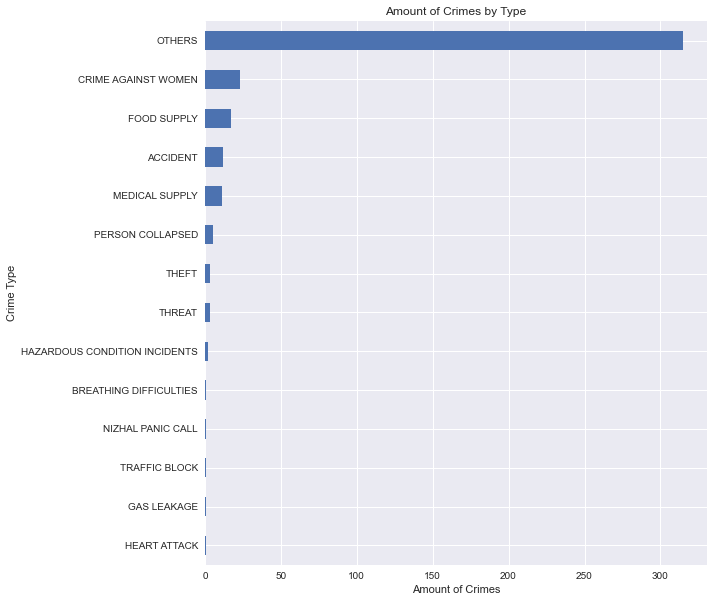

In [177]:
# Plot Bar Chart visualize Primary Types

plt.style.use('seaborn')
plt.figure(figsize=(9,10))
plt.title('Amount of Crimes by Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')
plt.grid(False)
# processed_data.groupby([processed_data['event_maintype']]).size().\
#                         sort_values(ascending=True).plot(kind='barh')

# This'll work too
processed_data['event_maintype'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [178]:
# Q. What percentage of events are classified to others?

total = processed_data.shape[0]
others_count = processed_data[processed_data['event_maintype'] == 'OTHERS'].count()[0]

print("Percentage of events classified to OTHERS is ", (others_count/total)*100, "%", sep="")

Percentage of events classified to OTHERS is 79.34508816120906%


##### We're now done with our data cleaning, now it's time for data preprocessing

In [179]:
# Save the current state as csv

# processed_data.to_csv("new_data.csv", index=False)

# Data Pre-processing

In [180]:
# Create a copy of processed data, from now on we will work on the newly created DataFrame

df = processed_data.copy()

In [181]:
df.head()

,info,event_maintype
0,arrack prepration in a house\n\nloc thottasse...,OTHERS
1,"caller informs that she was alone,she heard 3 ...",NIZHAL PANIC CALL
2,CALLER INFORMED SOME ONE SUSPICIOSLY SEEN NEAR...,OTHERS
3,"Illegal mining of sand Loc;- Chamravattom, ne...",OTHERS
4,caller hear a strange peson`s sound at back s...,THEFT


In [185]:
# print(string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# Funtion to remove punctuation
def removePunctuation(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

In [186]:
data = [x for x in df['info']]

In [187]:
# Function to remove the stopwords from the list of words

stop_words = stopwords.words('english')
def removeStopWords(wordList):
    wordList = [word for word in wordList if word not in stop_words]
    return wordList

In [188]:
# token_list = word_tokenize(text)

def textPreprocessing(text):
    text = removePunctuation(text)
    text = text.strip().replace("\n", "")
    text = re.sub("[0-9]", "", text)
    text_tokens = word_tokenize(text)
    text_tokens = [word for word in text_tokens if len(word) > 0]
    filtered_words = removeStopWords(text_tokens)
#     stemmed_words = stemWord(filtered_words)
    return filtered_words

In [189]:
new_data = [textPreprocessing(sent.lower()) for sent in data]

In [192]:
# Q. Show first 5 sentences after doing text preprocessing

new_data[:5]

[['arrack',
  'prepration',
  'houseloc',
  'thottassery',
  'veedu',
  'hari',
  'babu',
  'panamanna',
  'south',
  'ottapalam',
  'ps',
  'near',
  'panamanna',
  'south',
  'vayanasala'],
 ['caller',
  'informs',
  'aloneshe',
  'heard',
  'persons',
  'foot',
  'steps',
  'sound',
  'near',
  'houseneed',
  'police',
  'help',
  'sujathapallolil',
  'houseangadi',
  'poloc',
  'ranni',
  'thiruvalla',
  'routenear',
  'new',
  'india',
  'church',
  'god',
  'bandhicose',
  'churchranni',
  'ps'],
 ['caller',
  'informed',
  'one',
  'suspiciosly',
  'seen',
  'near',
  'home',
  'chungammannarkadu',
  'home',
  'near',
  'chungam',
  'sree',
  'maha',
  'vishnu',
  'temple'],
 ['illegal', 'mining', 'sand', 'loc', 'chamravattom', 'near', 'pump', 'house'],
 ['caller',
  'hear',
  'strange',
  'pesons',
  'sound',
  'back',
  'side',
  'home',
  'suspecting',
  'thief',
  'unra',
  'sundaram',
  'back',
  'side',
  'govt',
  'women',
  'hospital',
  'thycaud',
  'thampanoor',
  'ps'

In [193]:
mainDict = {}
for sent in new_data:
    for word in sent:
        if word not in mainDict:
            mainDict[word] = 1
        else:
            mainDict[word] += 1

In [195]:
# for k, v in mainDict.items():
#     print(k + ":   " + str(v))

## Let's try Gensim

In [196]:
# 1. Download Text8 corpus

text8_path = api.load('text8', return_path=True)
print("Using corpus from", text8_path)

Using corpus from C:\Users\rahuldecoded/gensim-data\text8\text8.gz


In [197]:
# 2. Train the Word2Vec model

# Using params from Word2Vec_FastText_Comparison
params = {
    'alpha': 0.05,
#     'vector_size': 100,
    'window': 5,
#     'epochs': 5,
    'min_count': 5,
    'sample': 1e-4,
    'sg': 1,
    'hs': 0,
    'negative': 5,
}
model = Word2Vec(Text8Corpus(text8_path), **params)
wv = model.wv
print("Using trained model", wv)

Using trained model <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000024ABB241080>


In [198]:
# Function to calculate similarity of a word with Police

def calcPoliceSimilarity(mainWord):
    relatedWords = ["police", "attack", "fear", "kidnap", "murder", "gun", \
                    "molestation", "abuse", "thief", "illegal", "theft", \
                    "murdered", "trespass", "drugs", "threat"]
    
    similarityScore = 0

    for word in relatedWords:
        try:
            score = wv.similarity(word, mainWord)
            if similarityScore < score:
                similarityScore = score
        except Exception as e:
            pass
    return similarityScore    

In [199]:
# Function to calculate similarity of a word with Ambulance

def calcAmbulanceSimilarity(mainWord):
    relatedWords = ["ambulance", "accident", "blood", "medicine", "ill", "illness", "heart", \
                    "kidney", "breathing", "fainted", "choking", "collapsed", 
                    "vomiting", "hospital"]
    
    similarityScore = 0
    for word in relatedWords:
        try:
            score = wv.similarity(word, mainWord)
            if similarityScore < score:
                similarityScore = score
        except Exception as e:
            pass
    return similarityScore   

In [200]:
# Function to calculate similarity of a word with Fire

def calcFireSimilarity(mainWord):
    relatedWords = ["fire", "gas"]
    
    similarityScore = 0

    for word in relatedWords:
        try:
            score = wv.similarity(word, mainWord)
            if similarityScore < score:
                similarityScore = score
        except Exception as e:
            pass
    return similarityScore   

In [201]:
# Checks if word is in vocabulary, and return dict with similarity scores if found.

def categorize(word):
    if word not in wv.vocab:
        return {}
#     currentScore = 0.069999
#     category = "Non Crime"
    try:
        scoreDict = {
            "Police": calcPoliceSimilarity(word),
            "Ambulance": calcAmbulanceSimilarity(word),
            "Fire": calcFireSimilarity(word)
        }
    except Exception as e:
        return {}
    return scoreDict
    

In [202]:
# Create copy of df

test = df.copy()
test.head()

,info,event_maintype
0,arrack prepration in a house\n\nloc thottasse...,OTHERS
1,"caller informs that she was alone,she heard 3 ...",NIZHAL PANIC CALL
2,CALLER INFORMED SOME ONE SUSPICIOSLY SEEN NEAR...,OTHERS
3,"Illegal mining of sand Loc;- Chamravattom, ne...",OTHERS
4,caller hear a strange peson`s sound at back s...,THEFT


In [203]:
# similarityScore and crimeCategory will be our new columns in out data
similarityScore = []
crimeCategory = []


# We'll be traversing to all sentences
for data in new_data:
    
    # it'll help us maintain highest score for each category    
    categoryWiseScore = {}
    
    # traversing every word in the cleaned sentence
    for word in data:
        pairs = categorize(word)
        if len(pairs) == 0:
            continue
        for k, v in pairs.items():
            if k not in categoryWiseScore:
                categoryWiseScore[k] = v
            else:
                if categoryWiseScore[k] < v:
                    categoryWiseScore[k] = v
    
    # details is a list of [category, score]
    details = []
    for k, v in categoryWiseScore.items():
        details.append([k, v])
        
    # sorting details wrt similarity score   
    details.sort(key=lambda x: x[1], reverse=True)
    
    
    # If highest score in details is 0.4 then we're classifying it as Non-crime
    if details[0][1] < 0.4:
        crimeCategory.append("Non Crime")
        similarityScore.append(details[0][1])
        continue
    
    
    if len(details) == 1:
        crimeCategory.append(details[0][0])
        similarityScore.append(details[0][1])
    else:
        # Creating a threshold to add the category in the crimeCategory list        
        if details[1][1] < 0.5:
            crimeCategory.append(details[0][0])
            similarityScore.append(details[0][1])
        else:
            crimeCategory.append(details[0][0] + ", " + details[1][0])
            similarityScore.append(str(details[0][1]) + ", " + str(details[1][1]))
    
    
test["Category"] = crimeCategory
test["Similarity Score"] = similarityScore
        

In [204]:
test.head()

,info,event_maintype,Category,Similarity Score
0,arrack prepration in a house\n\nloc thottasse...,OTHERS,Ambulance,0.421366
1,"caller informs that she was alone,she heard 3 ...",NIZHAL PANIC CALL,Police,1
2,CALLER INFORMED SOME ONE SUSPICIOSLY SEEN NEAR...,OTHERS,Police,0.507371
3,"Illegal mining of sand Loc;- Chamravattom, ne...",OTHERS,"Police, Fire","1.0, 0.5810086"
4,caller hear a strange peson`s sound at back s...,THEFT,"Ambulance, Police","1.0, 0.99999994"


In [205]:
category = test['Category'].value_counts()

In [206]:
properCat = {"Ambulance": 0,
             "Police": 0,
             "Fire": 0,
             "Non Crime": 0}
for k, v in category.items():
    if "Ambulance" in k:
        properCat["Ambulance"] += v
    if "Police" in k:
        properCat["Police"] += v
    if "Fire" in k:
        properCat["Fire"] += v
    if "Non Crime" in k:
        properCat["Non Crime"] += v

In [207]:
category_df = pd.DataFrame.from_dict(properCat, orient='index', columns=['frequency'])

In [220]:
category_df.head()

,frequency
Ambulance,255
Police,246
Fire,50
Non Crime,14


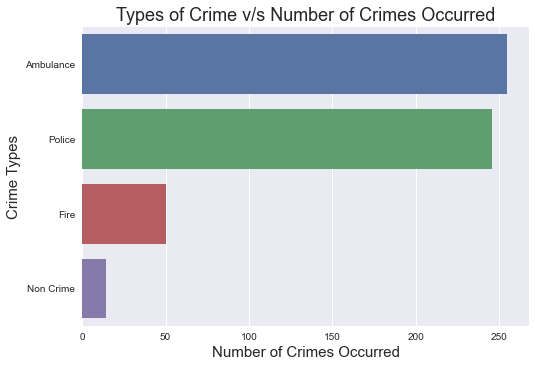

In [209]:
sns.barplot(x=category_df['frequency'], y=category_df.index , data=category_df)
plt.xlabel("Number of Crimes Occurred", fontsize=15)
plt.ylabel("Crime Types", fontsize=15)
plt.title("Types of Crime v/s Number of Crimes Occurred", fontsize=18)
plt.show()

In [210]:
data_df = test.copy()

In [211]:
# similarityScore and crimeCategory will be our new columns in out data
policeScore = []
ambulanceScore = []
fireScore = []

# We'll be traversing to all sentences
for data in new_data:
    
    # it'll help us maintain highest score for each category    
    categoryWiseScore = {}
    
    # traversing every word in the cleaned sentence
    for word in data:
        pairs = categorize(word)
        if len(pairs) == 0:
            continue
        for k, v in pairs.items():
            if k not in categoryWiseScore:
                categoryWiseScore[k] = v
            else:
                if categoryWiseScore[k] < v:
                    categoryWiseScore[k] = v
    policeScore.append(categoryWiseScore['Police'])
    ambulanceScore.append(categoryWiseScore['Ambulance'])
    fireScore.append(categoryWiseScore['Fire'])
    

data_df['Police'] = policeScore
data_df['Ambulance'] = ambulanceScore
data_df['Fire'] = fireScore

In [212]:
data_df.head()

,info,event_maintype,Category,Similarity Score,Police,Ambulance,Fire
0,arrack prepration in a house\n\nloc thottasse...,OTHERS,Ambulance,0.421366,0.328780,0.421366,0.305105
1,"caller informs that she was alone,she heard 3 ...",NIZHAL PANIC CALL,Police,1,1.000000,0.497274,0.426105
2,CALLER INFORMED SOME ONE SUSPICIOSLY SEEN NEAR...,OTHERS,Police,0.507371,0.507371,0.432553,0.325463
3,"Illegal mining of sand Loc;- Chamravattom, ne...",OTHERS,"Police, Fire","1.0, 0.5810086",1.000000,0.557047,0.581009
4,caller hear a strange peson`s sound at back s...,THEFT,"Ambulance, Police","1.0, 0.99999994",1.000000,1.000000,0.401048


In [213]:
data_np = data_df[['Police', 'Ambulance', 'Fire']].values

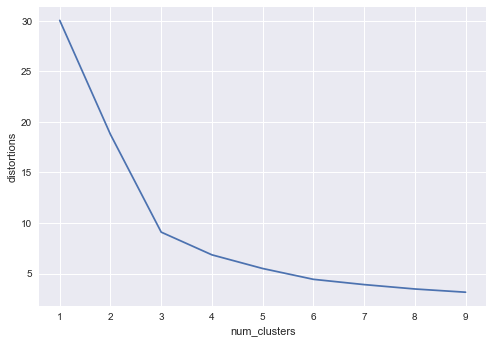

In [214]:
# Using KMeans to tell us, how many clusters are there in the Dataset

from sklearn.cluster import KMeans

distortions = []
num_clusters = range(1, 10)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    km = KMeans(i).fit(data_np)
    distortions.append(km.inertia_)

# Create a data frame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({"num_clusters": num_clusters, "distortions": distortions})

sns.lineplot(x="num_clusters", y="distortions", data = elbow_plot)
plt.xticks(num_clusters)
plt.show()
plt.close()

##### Using Elbow Plot we can easily see that there are 3 clusters in the database

# Validation

In [215]:
df = pd.read_csv('validation.csv', index_col='Unnamed: 0')

In [216]:
df = df[['Prediction', 'Correct']]

In [217]:
df = df.dropna()

In [218]:
df.reset_index(drop=True, inplace=True)
df = df.iloc[:-3, :]
df.head()

,Prediction,Correct
0,Ambulance,Police
1,Police,Police
2,Police,Police
3,Ambulance,Ambulance
4,Ambulance,Ambulance


In [219]:
print(accuracy_score(df['Correct'], df['Prediction']))
print(confusion_matrix(df['Correct'], df['Prediction']))
print(classification_report(df['Correct'], df['Prediction']))

0.7
[[11  0  0  1]
 [ 0  1  0  0]
 [ 0  0  3  1]
 [ 6  4  0 13]]
              precision    recall  f1-score   support

   Ambulance       0.65      0.92      0.76        12
        Fire       0.20      1.00      0.33         1
   Non Crime       1.00      0.75      0.86         4
      Police       0.87      0.57      0.68        23

   micro avg       0.70      0.70      0.70        40
   macro avg       0.68      0.81      0.66        40
weighted avg       0.80      0.70      0.72        40



In [1]:
!pip freeze > requirements.txt